<a href="https://colab.research.google.com/github/wolframalexa/humanities-data-analysis/blob/main/chap2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

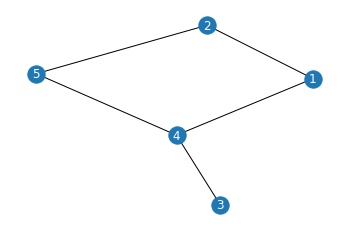

In [2]:
# Book Code: Making a character graph of Hamlet

import networkx as nx
import matplotlib.pyplot as plt

# Sample Graph
V = {1, 2, 3, 4, 5} # nodes
E = {(1, 2), (1, 4), (2, 5), (3, 4), (4, 5)} # edges


G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

nx.draw_networkx(G, font_color="white")
plt.axis('off');

In [33]:
import lxml.etree
import urllib.request as req

NSMAP = {'tei': 'http://www.tei-c.org/ns/1.0'}


def character_network(tree):
    """Construct a character interaction network.
    Construct a character interaction network for Shakespeare texts in
    the Folger Digital Text collection. Character interaction networks
    are constructed on the basis of successive speaker turns in the texts,
    and edges between speakers are created when their utterances follow
    one another.
    Arguments:
        tree: An lxml.ElementTree instance representing one of the XML
            files in the Folger Shakespeare collection.
    Returns:
        A character interaction network represented as a weighted,
        undirected NetworkX Graph.
    """
    G = nx.Graph()
    # extract a list of speaker turns for each scene in a play
    for scene in tree.iterfind('.//tei:div2[@type="scene"]', NSMAP):
        speakers = scene.findall('.//tei:sp', NSMAP)
        # iterate over the sequence of speaker turns...
        for i in range(len(speakers) - 1):
            # ... and extract pairs of adjacent speakers
            try:
                speaker_i = speakers[i].attrib['who'].split('_')[0].replace('#', '')
                speaker_j = speakers[i + 1].attrib['who'].split('_')[0].replace('#', '')
                # if the interaction between two speakers has already
                # been attested, update their interaction count
                if G.has_edge(speaker_i, speaker_j):
                    G[speaker_i][speaker_j]['weight'] += 1
                # else add an edge between speaker i and j to the graph
                else:
                    G.add_edge(speaker_i, speaker_j, weight=1)
            except KeyError:
                continue
    return G

from xml.dom import minidom
import lxml.html
import requests

# %%
url = 'http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/2-prep/Ham.xml'
res = requests.get(url)

tree = lxml.etree.fromstring(res.content)
tree = tree.getroottree()
G = character_network(tree.getroot())


# %%
print(f"N nodes = {G.number_of_nodes()}, N edges = {G.number_of_edges()}")

N nodes = 38, N edges = 73


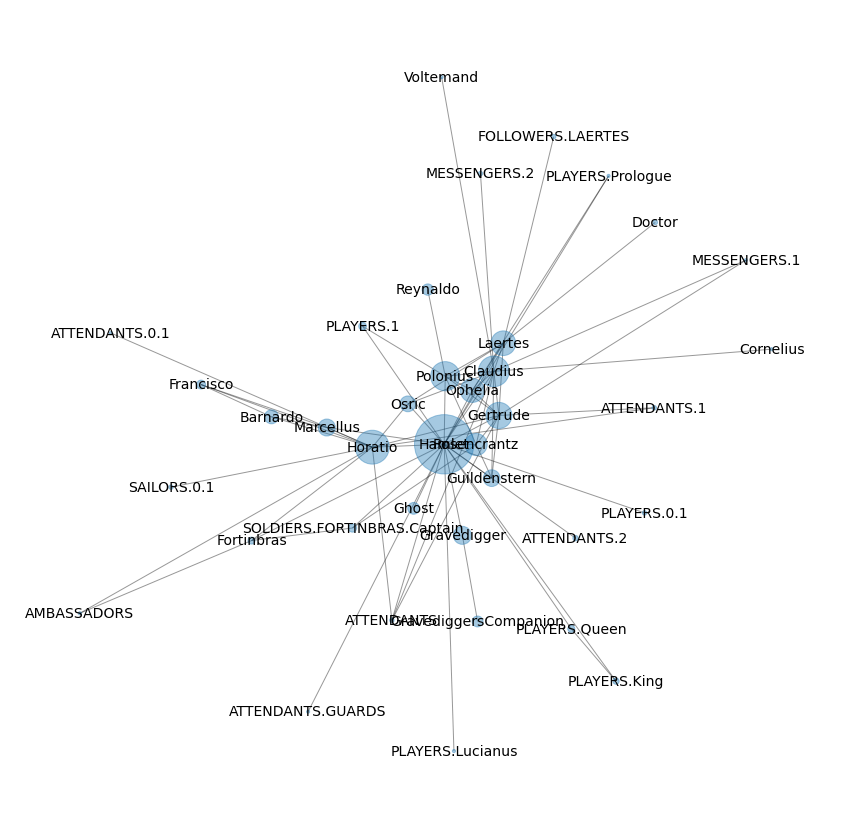

In [35]:
import collections

interactions = collections.Counter()

for speaker_i, speaker_j, data in G.edges(data=True):
    interaction_count = data['weight']
    interactions[speaker_i] += interaction_count
    interactions[speaker_j] += interaction_count

nodesizes = [interactions[speaker] * 5 for speaker in G]

# Create an empty figure of size 15x15
fig = plt.figure(figsize=(15, 15))
# Compute the positions of the nodes using the spring layout algorithm
pos = nx.spring_layout(G, k=0.5, iterations=200)
# Then, add the edges to the visualization
nx.draw_networkx_edges(G, pos, alpha=0.4)
# Subsequently, add the weighted nodes to the visualization
nx.draw_networkx_nodes(G, pos, node_size=nodesizes, alpha=0.4)
# Finally, add the labels (i.e. the speaker IDs) to the visualization
nx.draw_networkx_labels(G, pos, font_size=14)
plt.axis('off');

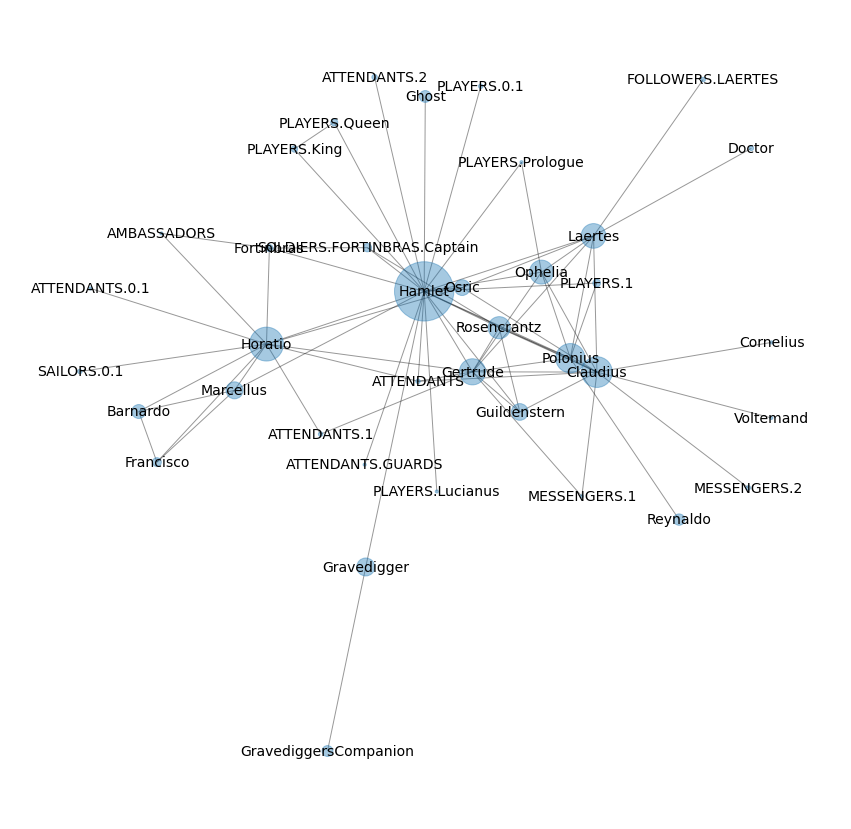

In [37]:
# unweighted graph
from copy import deepcopy
G0 = deepcopy(G)

for u, v, d in G0.edges(data=True):
    d['weight'] = 1

nodesizes = [interactions[speaker] * 5 for speaker in G0]

fig = plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G0, k=0.5, iterations=200)
nx.draw_networkx_edges(G0, pos, alpha=0.4)
nx.draw_networkx_nodes(G0, pos, node_size=nodesizes, alpha=0.4)
nx.draw_networkx_labels(G0, pos, font_size=14)
plt.axis('off');

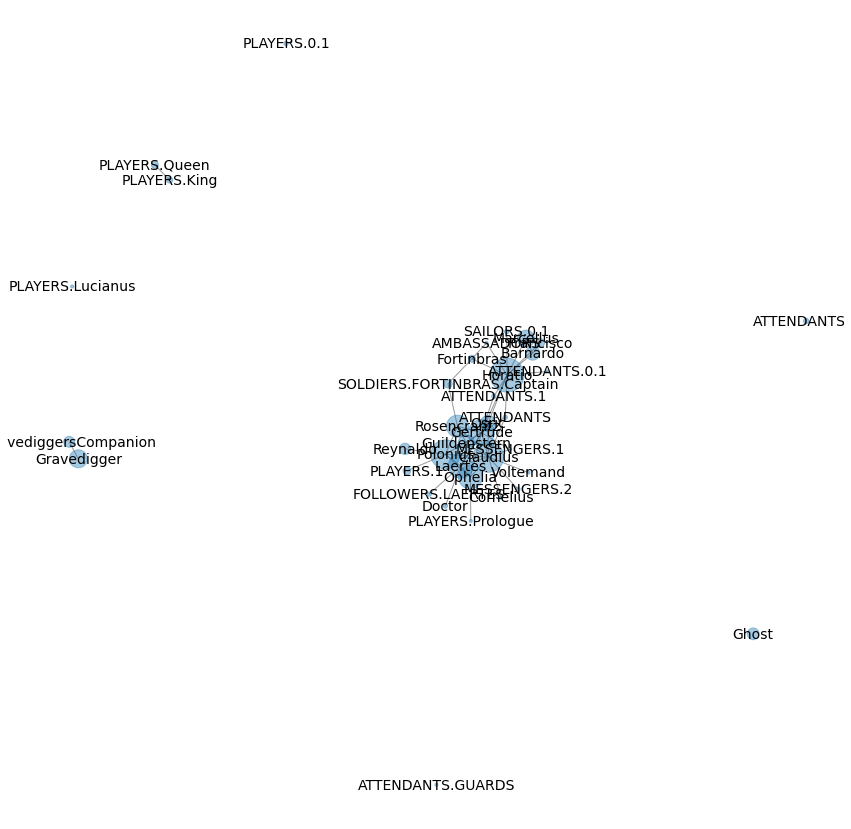

In [42]:
# without Hamlet
G0.remove_node('Hamlet')

fig = plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G0, k=0.5, iterations=200)
nodesizes = [interactions[speaker] * 5 for speaker in G0]
nx.draw_networkx_edges(G0, pos, alpha=0.4)
nx.draw_networkx_nodes(G0, pos, node_size=nodesizes, alpha=0.4)
nx.draw_networkx_labels(G0, pos, font_size=14)
plt.axis('off');

Hamlet seems to really tie the play together, which makes sense since he is the titular character.

In [43]:
# serialize into JSON format

import json
from networkx.readwrite import json_graph

with open('hamlet.json', 'w') as f:
    json.dump(json_graph.node_link_data(G), f)

with open('hamlet.json') as f:
    d = json.load(f)

G = json_graph.node_link_graph(d)
print(f"Graph with {len(G.nodes())} nodes and {len(G.edges())} edges.")

Graph with 38 nodes and 73 edges.


In [50]:
# My code from here
# Easy

# Read Joost van den Vondel works
import csv, urllib.request

url = 'http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/2-prep/vondel-stcn.csv'
response = urllib.request.urlopen(url)
lines = [l.decode('utf-8') for l in response.readlines()]
cr = csv.reader(lines)
cr = list(cr) # transform from csv.reader object to list

for row in range(1,10):
    print(cr[row])

['1642', 'Hiervsalem verwoest. Trevrspel.', 'Joost van den Vondel 1587-1679', 'Matthijsz, Paulus Amsterdam']
['1641', "Gysbrecht van Aemstel, d'ondergangh van zijn stad en zijn ballingschap. Treurspel.", 'Joost van den Vondel 1587-1679', 'Houthaeck, Dirck Cornelisz Amsterdam']
['1720', 'Joseph in Egypten. Trevrspel.', 'Joost van den Vondel 1587-1679', 'Oosterwyk, Johannes van Amsterdam']
['17XX', 'Lucifer. Treurspel.', 'Joost van den Vondel 1587-1679', 'Wees, Abraham de I Amsterdam']
['17XX', 'De heerlyckheit der kercke haer ingang, opgang, en voortgang.', 'Joost van den Vondel 1587-1679', 'Oude druckerije, de Köln']
['1702', 'Brieven der heilige maeghden, martelaressen.', 'Joost van den Vondel 1587-1679', 'Lamsvelt, Jan Amsterdam']
['17XX', "Gysbregt van Aemstel, d'ondergank van zyne stad en ballingschap. Treur-spel.", 'Joost van den Vondel 1587-1679', 'Veer, Pieter van der Utrecht']
['1639', 'Maeghden. Trevrspel.', 'Joost van den Vondel 1587-1679', 'Wees, Abraham de I Amsterdam']
['

In [53]:
# 5 most common publishers
import collections

publishers = collections.Counter()
for entry in cr:
    publishers[entry[3]] += 1

print(publishers.most_common(5))

[('Wees, Abraham de I, wed. Amsterdam', 34), ('Wees, Joannes de Amsterdam', 29), ('Oosterwyk, Johannes van Amsterdam', 28), ('Brakman, Pieter Amersfoort', 23), ('Bruyn, Cornelis de Amsterdam', 21)]


In [65]:
# Extract most common places of publishers
keys = publishers.keys()
places = collections.Counter()

for item in keys:
  words = item.split(' ')
  places[words[-1]] += 1

print(places.most_common(5))

[('Amsterdam', 49), ('Rotterdam', 3), ('Schiedam', 3), ('Köln', 2), ('Dordrecht', 2)]


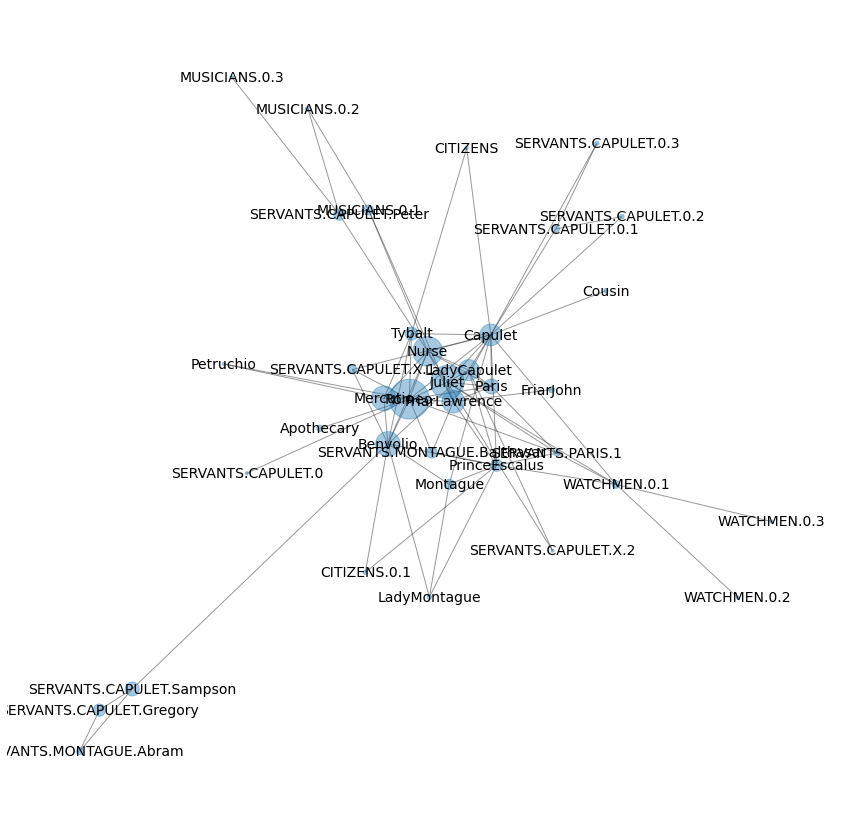

In [67]:
# Moderate

# Visualize character network for Romeo and Juliet
url = 'http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/2-prep/Rom.xml'
res = requests.get(url)

tree = lxml.etree.fromstring(res.content)
tree = tree.getroottree()
R = character_network(tree.getroot())

interactionsR = collections.Counter()

for speaker_i, speaker_j, data in R.edges(data=True):
    interaction_count = data['weight']
    interactionsR[speaker_i] += interaction_count
    interactionsR[speaker_j] += interaction_count

nodesizes = [interactionsR[speaker] * 5 for speaker in R]

# Create an empty figure of size 15x15
fig = plt.figure(figsize=(15, 15))
# Compute the positions of the nodes using the spring layout algorithm
pos = nx.spring_layout(R, k=0.5, iterations=200)
# Then, add the edges to the visualization
nx.draw_networkx_edges(R, pos, alpha=0.4)
# Subsequently, add the weighted nodes to the visualization
nx.draw_networkx_nodes(R, pos, node_size=nodesizes, alpha=0.4)
# Finally, add the labels (i.e. the speaker IDs) to the visualization
nx.draw_networkx_labels(R, pos, font_size=14)
plt.axis('off');

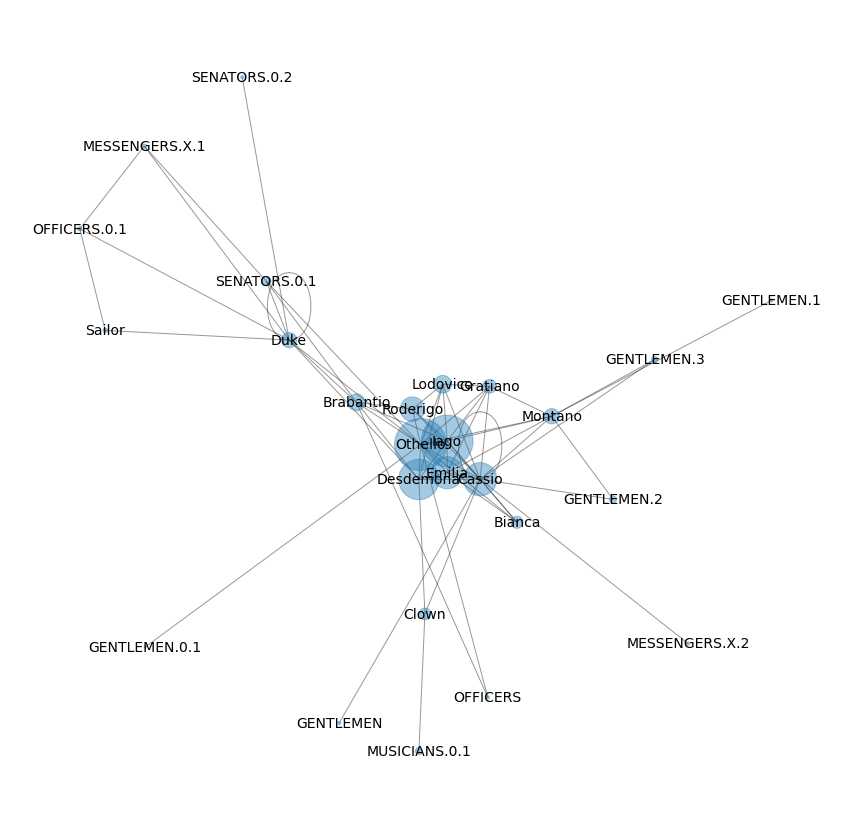

In [69]:
# Visualize character network for Othello
url = 'http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/2-prep/Oth.xml'
res = requests.get(url)

tree = lxml.etree.fromstring(res.content)
tree = tree.getroottree()
O = character_network(tree.getroot())

interactionsO = collections.Counter()

for speaker_i, speaker_j, data in O.edges(data=True):
    interaction_count = data['weight']
    interactionsO[speaker_i] += interaction_count
    interactionsO[speaker_j] += interaction_count

nodesizes = [interactionsO[speaker] * 5 for speaker in O]

fig = plt.figure(figsize=(15, 15))
pos = nx.spring_layout(O, k=0.5, iterations=200)
nx.draw_networkx_edges(O, pos, alpha=0.4)
nx.draw_networkx_nodes(O, pos, node_size=nodesizes, alpha=0.4)
nx.draw_networkx_labels(O, pos, font_size=14)
plt.axis('off');

In Othello, the main characters overlap by a lot - they are quite close - whereas the web in Romeo and Juliet is more tangled, since there is more interaction between secondary characters and the families are more intertwined.

In [70]:
# Nodes and Edges

print(f"For Hamlet: N nodes = {G.number_of_nodes()}, N edges = {G.number_of_edges()}")
print(f"For Romeo and Juliet: N nodes = {R.number_of_nodes()}, N edges = {R.number_of_edges()}")
print(f"For Othello: N nodes = {O.number_of_nodes()}, N edges = {O.number_of_edges()}")

For Hamlet: N nodes = 38, N edges = 73
For Romeo and Juliet: N nodes = 37, N edges = 83
For Othello: N nodes = 26, N edges = 64


In [72]:
print("Hamlet density:", nx.density(G))
print("Romeo and Juliet density:", nx.density(R))
print("Othello density:", nx.density(O))

Hamlet density: 0.10384068278805121
Romeo and Juliet density: 0.12462462462462462
Othello density: 0.19692307692307692


Othello has fewer nodes and edges than the other plays, which means it both has fewer characters and fewer interactions. While Hamlet and Romeo and Juliet have approximately the same number of characters (nodes), there are more interactions (edges). However, Othello has a higher network density than Hamlet and Romeo and Juliet, showing that more of its characters have interactions with each other.

In [87]:
# Challenging
# unweighted
degHamlet = list(nx.degree(G))
degHamlet.sort(key=lambda y: y[1])
print("Top characters in Hamlet:", degHamlet[-3:])

degRJ = list(nx.degree(R))
degRJ.sort(key=lambda y: y[1])
print("Top characters in Romeo and Juliet:", degRJ[-3:])

degOth = list(nx.degree(O))
degOth.sort(key=lambda y: y[1])
print("Top characters in Othello:", degOth[-3:])

Top characters in Hamlet: [('Horatio', 12), ('Claudius', 13), ('Hamlet', 23)]
Top characters in Romeo and Juliet: [('Benvolio', 11), ('Romeo', 14), ('Capulet', 16)]
Top characters in Othello: [('Duke', 10), ('Othello', 14), ('Cassio', 16)]


Hamlet has the most interactions by far - which is to be expected. It's surprising that Capulet, and not Romeo or Juliet, is the busiest character in R&J, and that Juliet does not even crack the top 3! As for Othello, he is the second most active, after Cassio.

In [92]:
# weighted

degHamlet = list(nx.degree(G, weight='weight'))
degHamlet.sort(key=lambda y: y[1])
print("Top characters in Hamlet:", degHamlet[-3:])

degRJ = list(nx.degree(R, weight='weight'))
degRJ.sort(key=lambda y: y[1])
print("Top characters in Romeo and Juliet:", degRJ[-3:])

degOth = list(nx.degree(O, weight='weight'))
degOth.sort(key=lambda y: y[1])
print("Top characters in Othello:", degOth[-3:])

Top characters in Hamlet: [('Claudius', 189), ('Horatio', 230), ('Hamlet', 704)]
Top characters in Romeo and Juliet: [('Nurse', 176), ('Juliet', 227), ('Romeo', 318)]
Top characters in Othello: [('Desdemona', 327), ('Iago', 537), ('Othello', 544)]


Once we weight, Horatio appears more important than Claudius, although Hamlet remains the most active. The women characters of Romeo and Juliet, Juliet and the Nurse, are finally present on the leaderboard. This reflects that their contributions are mostly in private - Juliet and the Nurse don't have big speeches the way their male counterparts do, but they do talk quite a bit. Finally, Cassio falls out of the top three, yielding the top spot to Othello, with Iago and Desdemona behind him.

In [172]:
# Van Gogh Letter
NSMAP = {None: 'http://www.tei-c.org/ns/1.0',
         'vg': 'http://www.vangoghletters.org/ns/'}

url = 'http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/2-prep/vangoghxml/let001.xml'
res = requests.get(url)
tree = lxml.etree.fromstring(res.content)
tree = tree.getroottree() # turn into ElementTree

for item in tree.findall('.//author', NSMAP):
  print("Letter author is", item.text) 

for item in tree.findall('.//vg:addressee', NSMAP):
  print("Letter addressee is", item.text)

# This took a really long time because of namespaces - did not realize that you had to specify NSMAP in the find function. First could not find anything -> checked XPATH 
# -> used {} for namespace -> used NSMAP 

Letter author is Vincent van Gogh
Letter addressee is Theo van Gogh


In [174]:
# Find all authors and addressees for Van Gogh's Letters
authors = []
addressees = []

for i in range(1,903):
  url = 'http://raw.githubusercontent.com/wolframalexa/humanities-data-analysis/main/2-prep/vangoghxml/let' + str(i).zfill(3) + '.xml'
  res = requests.get(url)
  tree = lxml.etree.fromstring(res.content)
  tree = tree.getroottree() # turn into ElementTree

  for item in tree.findall('.//author', NSMAP):
    authors.append(item.text) 

  for item in tree.findall('.//vg:addressee', NSMAP):
    addressees.append(item.text)

In [183]:
# Letters sent by Vincent
print("Sent:", authors.count('Vincent van Gogh'))

# Letters recieved by Vincent
print("Received:", addressees.count('Vincent van Gogh'))

# Most common recipients of Vincent's letters
recipients = collections.Counter()
count = 0
for i in range(0, len(authors)):
  if authors[i] == 'Vincent van Gogh':
    recipients[addressees[i]] += 1
print(recipients.most_common(5))

Sent: 819
Received: 83
[('Theo van Gogh', 651), ('Anthon van Rappard', 58), ('Emile Bernard', 22), ('Willemien van Gogh', 21), ('Anna van Gogh-Carbentus', 8)]
